In [4]:
import pandas as pd
import matplotlib.pyplot as mp
import seaborn as sns
import numpy as np


In [5]:
train_df = pd.read_csv("/../Users/modx/Desktop/playground-series-s3e1/train.csv")

train_df.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


In [6]:
test_df = pd.read_csv("/../Users/modx/Desktop/playground-series-s3e1/test.csv")

test_df.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,37137,1.7062,35.0,4.966368,1.096539,1318.0,2.844411,39.75,-121.85
1,37138,1.3882,22.0,4.187035,1.098229,2296.0,3.180218,33.95,-118.29
2,37139,7.7197,21.0,7.129436,0.959276,1535.0,2.888889,33.61,-117.81
3,37140,4.6806,49.0,4.769697,1.048485,707.0,1.743590,34.17,-118.34
4,37141,3.1284,25.0,3.765306,1.081633,4716.0,2.003827,34.17,-118.29


In [7]:
#check NA

train_df.isna().sum()

id             0
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [8]:
train_df.shape, test_df.shape

((37137, 10), (24759, 9))

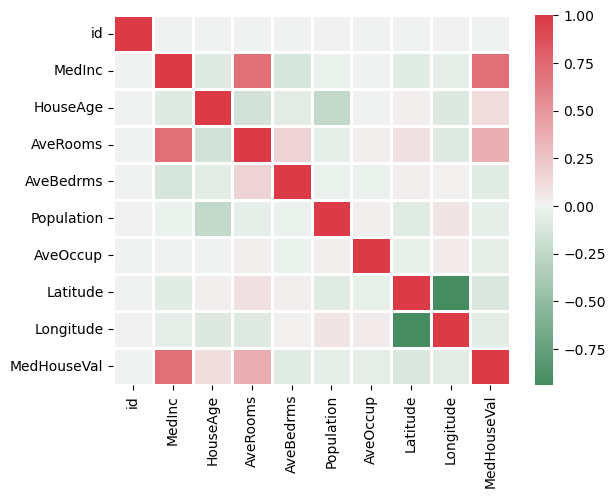

In [9]:
# plotting correlation heatmap

cmap = sns.diverging_palette(500, 10, as_cmap=True)
ans=sns.heatmap(train_df.corr(),  linewidths=1, cmap=cmap, center=0)
  
# displaying heatmap
mp.show()

In [10]:
from lightgbm.sklearn import LGBMRegressor
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [11]:
#seperate out features

features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
target = 'MedHouseVal'

In [12]:
#people are reporting is that adding original data (the data on which the Deep Learning model that was used to 
#generate the data for this competition was trained) helps.

In [13]:
from sklearn.datasets import fetch_california_housing

original_data = fetch_california_housing()
train_df = train_df.drop(columns='id')

original_data = pd.DataFrame(data=np.hstack([original_data['data'], original_data['target'].reshape(-1, 1)]), columns=train_df.columns)

#concat original data with the current one
train_df = pd.concat([train_df, original_data]).reset_index(drop=True)

In [30]:
clfs = []
rmses = []
N_ESTIMATORS = 100_000

params= {
 'lambda_l1': 1.945,
 'num_leaves': 87,
 'feature_fraction': 0.79,
 'bagging_fraction': 0.93,
 'bagging_freq': 4,
 'min_data_in_leaf': 103,
 'max_depth': 17,
}

kf = KFold(n_splits=10, random_state=42, shuffle=True)


for train_index, val_index in kf.split(train_df):
    X_train, X_val = train_df[features].loc[train_index], train_df[features].loc[val_index]
    y_train, y_val = train_df[target][train_index], train_df[target][val_index]
    
    clf = LGBMRegressor(learning_rate=0.02, n_estimators=N_ESTIMATORS, metric='rmse', **params)
    clf.fit(X_train.values, y_train, eval_set=[(X_val, y_val)], callbacks=[lgbm.early_stopping(85, verbose=True)])
    preds = clf.predict(X_val.values)
    
    predict1= clf.predict(X_val.values)

    
    clfs.append(clf)
    rmses.append(mean_squared_error(y_val, preds, squared=False))
    
print(f'mean RMSE across all folds: {np.mean(rmses)}')

[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't improve for 85 rounds
Early stopping, best iteration is:
[590]	valid_0's rmse: 0.512235
[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] lambda_l1 is set=1

In [15]:
#catboost model

In [16]:
import tensorflow

tensorflow.test.is_gpu_available()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [17]:
from catboost import CatBoostRegressor

rmses = []
kf = KFold(n_splits=10, random_state=1, shuffle=True)
for train_index, val_index in kf.split(train_df):
    X_train, X_val = train_df[features].loc[train_index], train_df[features].loc[val_index]
    y_train, y_val = train_df[target][train_index], train_df[target][val_index]

    clf = CatBoostRegressor(iterations=N_ESTIMATORS,random_state = 42, loss_function='RMSE')
    clf.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=1000, verbose=False)
    
    
    preds = clf.predict(X_val.values)
    
    clfs.append(clf)
    rmses.append(mean_squared_error(y_val, preds, squared=False))
print(f'mean RMSE across all folds: {np.mean(rmses)}')

mean RMSE across all folds: 0.519766462989854


In [48]:
from xgboost import XGBRegressor

clf = XGBRegressor(learning_rate=0.025, n_estimators=1000)
clf.fit(X_train, y_train)
preds = clf.predict(X_val.values)
    
clfs.append(clf)
rmses.append(mean_squared_error(y_val, preds, squared=False))
print(f'mean RMSE across all folds: {np.mean(rmses)}')

mean RMSE across all folds: 0.5195037801294129


In [49]:
#prediction on test

test_preds = []

for clf in clfs:
    preds = clf.predict(test_df[features].values)
    test_preds.append(preds)

In [50]:
#We can now take the mean of our predictions

test_preds = np.stack(test_preds).mean(0)
test_preds


array([0.65164501, 1.06472801, 4.03048482, ..., 1.21864117, 3.61033443,
       3.49091259])

In [51]:
submission = pd.DataFrame(data={'id': test_df.id, 'MedHouseVal': test_preds})
submission.head()

,id,MedHouseVal
0,37137,0.651645
1,37138,1.064728
2,37139,4.030485
3,37140,3.368283
4,37141,2.474366


In [54]:
submission.to_csv('submission_5.csv', index=False)

In [53]:
#Calculate r2

from sklearn.metrics import r2_score

r2 = r2_score(y_val, predict1)

print(r2)

0.798491010242075


In [ ]:
#notes

#MSE

#lower the value better the accuracy, we cannot o/p the accuracy of a regression model in terms of percentages. that can be done
#for classification problems

#gradiant boosting


#light gbm
#gradiant boosting framework based on decision tree

#xg boost


